# DATA SCIENCE CHALLENGE #4 - SERIES DE TIEMPO

+ Pronosticar las ventas de un producto o de una categoría es un desafío recurrente para cualquier ecommerce;
+ En este caso, el desafío va a ser pronosticar la cantidad de unidades diarias que van a vender 3 categorías distintas de MELI;
+ El dataset `series.csv` tiene las ventas en unidades diarias de 3 categorías que poseen un id único y su fecha de venta;
+ El objetivo de este desafío es construir un modelo de forecast que permita estimar las ventas de 3 semanas a nivel diario utilizando la historia de ventas de la categoría. Es decir, predecir las ventas de los siguientes 21 días. Las métricas y la medición de la performance del forecast son un punto clave de este desafío.

# Loading modules and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.utils.statistics import plot_acf, plot_pacf, stationarity_test_kpss, check_seasonality
from darts.models import NaiveSeasonal, AutoARIMA

# Loading the data

In [2]:
## loading the data used for this challenge
df = pd.read_csv(filepath_or_buffer = '../data/series.csv')

# Tidying up the data

In [3]:
## sorting the values in the dataframe by category and date, such that instances of the same category
## are aligned rowise and ordered sequentially over time
df = df.sort_values(by = ['CATEGORY', 'DATE'])

## parsing the date from object to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

## calculating the amount of time ellapsed between observations
df['time_ellapsed'] = (df.DATE - df.groupby('CATEGORY').DATE.shift(1)).dt.days

# Visualizing the data

#### What is the period originally covered by the time series?

In [4]:
## calculating the start and end date of the time series for each category
dates_by_category = df.groupby('CATEGORY').DATE.apply(lambda x: {'start': min(x), 'end': max(x)}).reset_index().pivot(index = 'CATEGORY', columns = 'level_1', values = 'DATE').reset_index()

## iterating across rows to print the start and end dates of each time series
for row in dates_by_category.iterrows():
    print(f'{row[1][0]} starts on {row[1][1]} and ends on {row[1][2]}.')

CATEG-1 starts on 2021-11-12 00:00:00 and ends on 2018-10-16 00:00:00.
CATEG-2 starts on 2021-11-12 00:00:00 and ends on 2018-10-16 00:00:00.
CATEG-3 starts on 2021-11-12 00:00:00 and ends on 2018-09-24 00:00:00.


#### How does the number of units sold vary over time for each product?

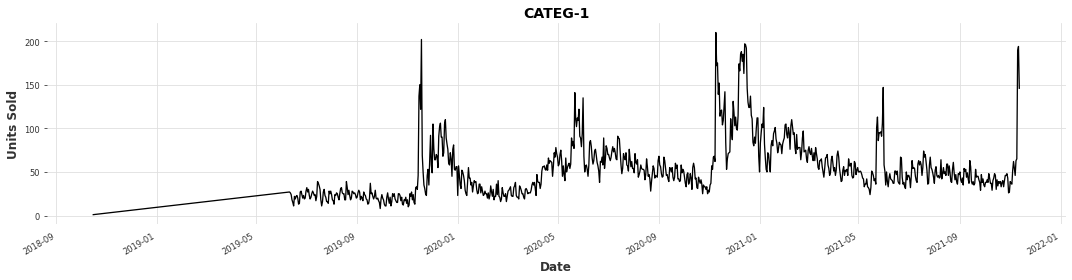

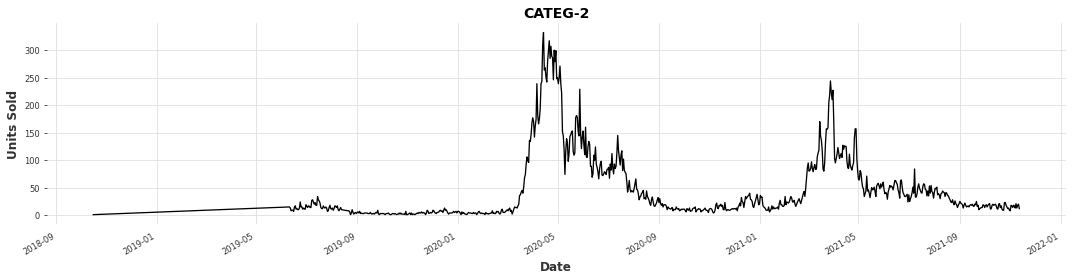

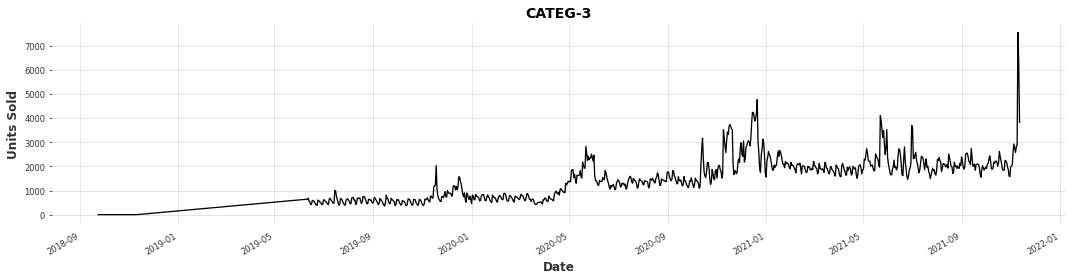

In [5]:
## plotting each of the categories separatelly
for category in df.CATEGORY.unique():
    df.loc[df.CATEGORY == category, ['DATE', 'UNITS_SOLD']].set_index(['DATE']).plot(figsize = (15, 4))
    plt.xlabel(xlabel = 'Date', fontdict = {'weight': 'bold', 'size': 12})
    plt.ylabel(ylabel = 'Units Sold', fontdict = {'weight': 'bold', 'size': 12})
    plt.title(label = category, fontdict = {'weight': 'bold', 'size': 14})
    plt.legend('',frameon=False)
    plt.tight_layout()
    plt.show()

#### How does the number of units sold compare across products over time?

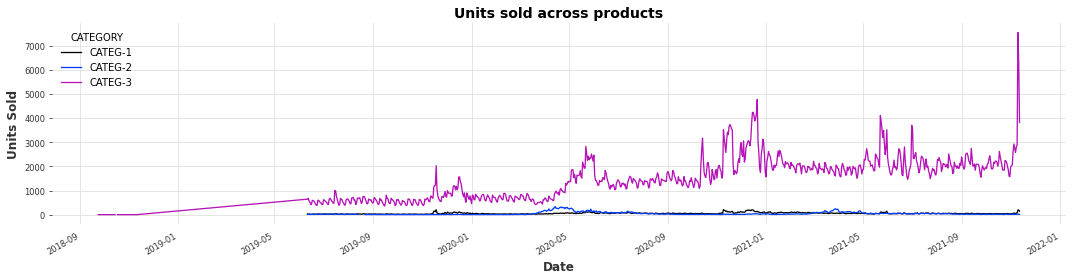

In [6]:
## plotting all categories in the same graph
df.drop(columns = ['time_ellapsed']).pivot_table(index='DATE',columns='CATEGORY',values='UNITS_SOLD',aggfunc='sum').plot(figsize = (15, 4))
plt.xlabel(xlabel = 'Date', fontdict = {'weight': 'bold', 'size': 12})
plt.ylabel(ylabel = 'Units Sold', fontdict = {'weight': 'bold', 'size': 12})
plt.title(label = 'Units sold across products', fontdict = {'weight': 'bold', 'size': 14})
plt.tight_layout()
plt.show()

#### Are there any gaps in the time series? If so, how long did day take?

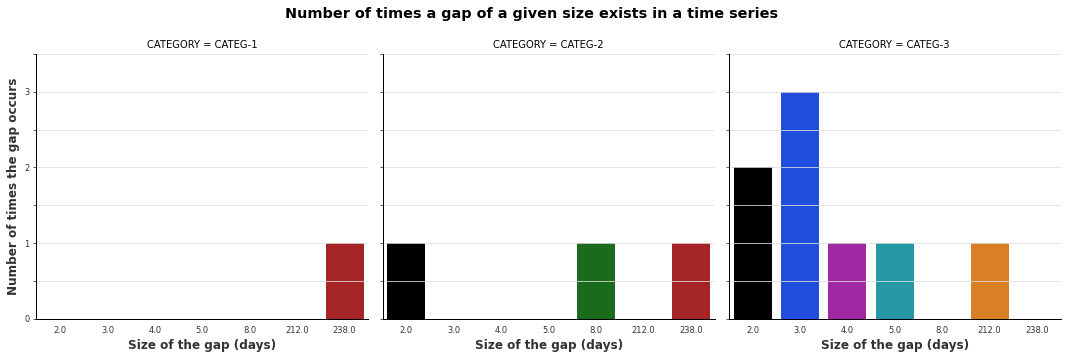

In [7]:
## creating a dataframe to encode the number of time the gaps of each size are observed within
## each product category
df_gaps = df.groupby(['CATEGORY']).time_ellapsed.value_counts().reset_index(name = 'gap_count')

## creating a plot to visualize how may gaps and for how long do they exist in each time series
ax = sns.catplot(x = 'time_ellapsed', y = 'gap_count', col = 'CATEGORY', 
                 data = df_gaps.loc[df_gaps.time_ellapsed > 1, :], kind = 'bar')
ax.set_yticklabels(labels = [0, '', 1, '', 2, '', 3, ''])
ax.fig.suptitle('Number of times a gap of a given size exists in a time series', fontsize = 'x-large', fontweight = 'bold')
ax.fig.subplots_adjust(top = 0.85)
ax.set_axis_labels(x_var = 'Size of the gap (days)', y_var = 'Number of times the gap occurs', fontweight = 'bold', fontsize = 12)
plt.show()

#### What are the missing dates for each product?

In [29]:
## printing the dates that should be used to drop the hiatus from the beginning of the time series
for row in df.loc[df.time_ellapsed > 10, ['CATEGORY', 'DATE']].iterrows():
    print(f'{row[1][0]} should start on {row[1][1]} in order to get rid of the hiatus on the beginning of its time series.')
    
## dropping the dates 
df_without_start = df.loc[df.DATE >= df[df. time_ellapsed > 10].DATE.unique()[0], :]

## calculating the start and end date of the time series for each category
dates_by_category = df_without_start.groupby('CATEGORY').DATE.apply(lambda x: {'start': min(x), 'end': max(x)}).reset_index().pivot(index = 'CATEGORY', columns = 'level_1', values = 'DATE').reset_index()

## iterating across rows to print the start and end dates of each time series
for row in dates_by_category.iterrows():
    print(f'{row[1][0]} now starts on {row[1][2]} and ends on {row[1][1]} ({(row[1][1] - row[1][2]).days} days in the time series).')

CATEG-1 should start on 2019-06-11 00:00:00 in order to get rid of the hiatus on the beginning of its time series.
CATEG-2 should start on 2019-06-11 00:00:00 in order to get rid of the hiatus on the beginning of its time series.
CATEG-3 should start on 2019-06-11 00:00:00 in order to get rid of the hiatus on the beginning of its time series.
CATEG-1 now starts on 2019-06-11 00:00:00 and ends on 2021-11-12 00:00:00 (885 days in the time series).
CATEG-2 now starts on 2019-06-11 00:00:00 and ends on 2021-11-12 00:00:00 (885 days in the time series).
CATEG-3 now starts on 2019-06-11 00:00:00 and ends on 2021-11-12 00:00:00 (885 days in the time series).


In [9]:
## creating a date range to reindex the dataframe and fill in the missing dates
idx = pd.date_range(dates_by_category.start.unique()[0], dates_by_category.end.unique()[0])
## creating a multindex so that we can reindex the dataframe by date and category
idx = pd.MultiIndex.from_product([idx, df_without_start.CATEGORY.unique()], names=['DATE', 'CATEGORY'])
## reindexing the dataframe to complete the missing observations
df_complete = df_without_start.set_index(['DATE', 'CATEGORY']).reindex(index = idx).reset_index()
## reordering the dataframe
df_complete = df_complete.sort_values(['CATEGORY', 'DATE'])
print(f'The original dataframe contained {df.shape[0]} rows. Removing the hiatus for each category reduced the number of rows to {df_without_start.shape[0]}, and filling in the missing dates increased it to {df_complete.shape[0]} rows.')

The original dataframe contained 2686 rows. Removing the hiatus for each category reduced the number of rows to 2650, and filling in the missing dates increased it to 2658 rows.


In [10]:
## looking at all the missing dates that were inputed in the process above - looks like all of them are from CATEG-2
## also, most of these missing values comes from a sequence of days with no data, whereas there is a single observation
## in Oct 2019 with missing data
df_complete.loc[df_complete.UNITS_SOLD.isna(), :]

,DATE,CATEGORY,UNITS_SOLD,time_ellapsed
193,2019-08-14,CATEG-2,NaN,NaN
196,2019-08-15,CATEG-2,NaN,NaN
199,2019-08-16,CATEG-2,NaN,NaN
202,2019-08-17,CATEG-2,NaN,NaN
205,2019-08-18,CATEG-2,NaN,NaN
208,2019-08-19,CATEG-2,NaN,NaN
211,2019-08-20,CATEG-2,NaN,NaN
412,2019-10-26,CATEG-2,NaN,NaN


In [11]:
## are there any records of zero units sold?
df_complete[df_complete.UNITS_SOLD == 0]

,DATE,CATEGORY,UNITS_SOLD,time_ellapsed


In [12]:
## since there are not records of no unit sold, I presume that this missing data was due to an error in data
## storage or something like that. In order not to lose this information, I'll use a simple interpolation
df_complete['Interpolated'] = df_complete.groupby('CATEGORY').UNITS_SOLD.apply(lambda x: x.interpolate())

#### What is the degree of auto-correlation in the time series?

In [13]:
## preparing the data to feed it into a TimeSeries object
time_series = df_complete.loc[:, ['DATE', 'CATEGORY', 'Interpolated']]
## creating the time series object
time_series = TimeSeries.from_group_dataframe(df = time_series, group_cols = 'CATEGORY', time_col = 'DATE', value_cols = 'Interpolated', freq = 'D')
## setting the frequency for a daily time series
TIME_SERIES_FREQUENCY = 365

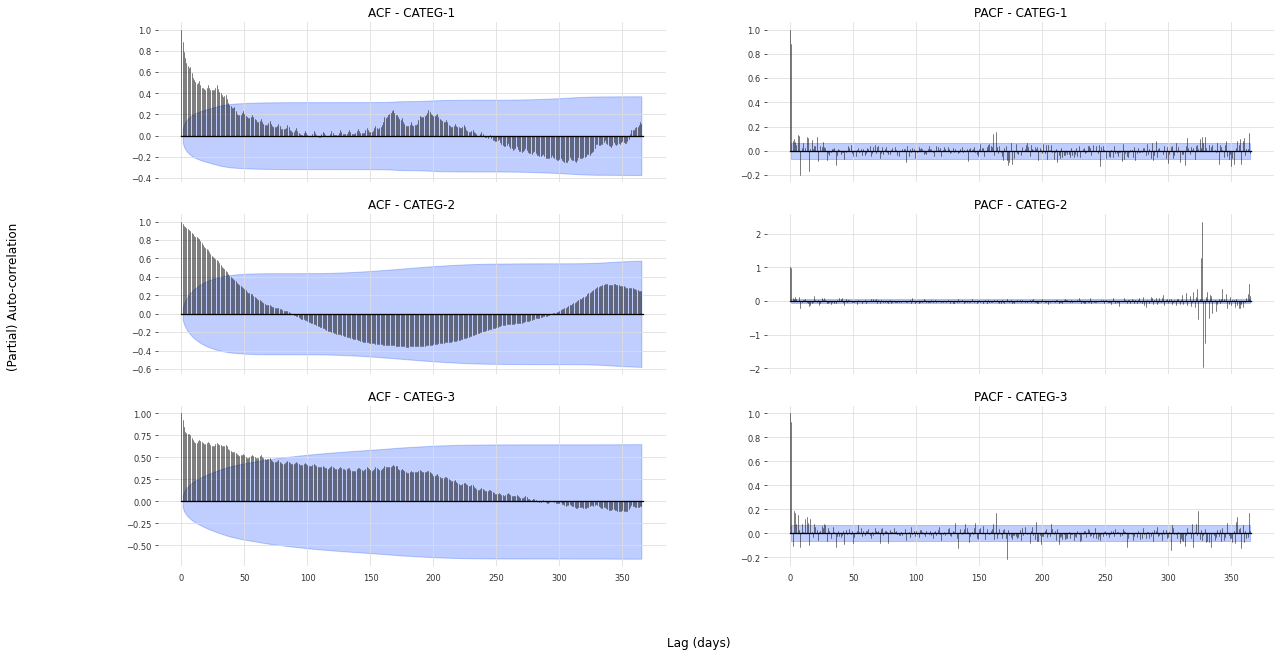

In [14]:
## plotting the ACF and PACF for each time series
fig, ax = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize = (20, 10))
labels = df_complete.CATEGORY.unique()
for idx_ts, ts in enumerate(time_series):
    plot_acf(ts = ts, max_lag = TIME_SERIES_FREQUENCY, axis = ax[idx_ts][0])
    plot_pacf(ts = ts, max_lag = TIME_SERIES_FREQUENCY, axis = ax[idx_ts][1])
    ax[idx_ts][0].set_title(f'ACF - {labels[idx_ts]}')
    ax[idx_ts][1].set_title(f'PACF - {labels[idx_ts]}')
    fig.supxlabel('Lag (days)')
    fig.supylabel('(Partial) Auto-correlation')

In [26]:
for idx_ts, ts in enumerate(time_series):
    # checking whether there is evidence of seasonality in the time series
    seasonality_test = check_seasonality(ts = ts, max_lag = TIME_SERIES_FREQUENCY)
    # checking whether there is a trend in the time series
    kpss_test = stationarity_test_kpss(ts = ts)
    # printing the seasonality results
    if seasonality_test[0]:
        print(f'There is evidence to suggest that the time series for {labels[idx_ts]} has a seasonal component, with periodicity of {seasonality_test[1]}.')
    else:
        print(f'There is no evidence to suggest that the time series for {labels[idx_ts]} has a seasonal component.')
    
    if kpss_test[1] <= 0.05:
        print(f'There is evidence to suggest that the time series for {labels[idx_ts]}is unlikely to be stationary (KPSS statistic: {kpss_test[0]}).')
    else:
        print(f'There is evidence to suggest that the time series for {labels[idx_ts]} is likely to be stationary (KPSS statistic: {kpss_test[0]}).')
    print('-' * 115)

There is evidence to suggest that the time series for CATEG-1 has a seasonal component, with periodicity of 7.
There is evidence to suggest that the time series for CATEG-1is unlikely to be stationary (KPSS statistic: 1.1408720826524636).
-------------------------------------------------------------------------------------------------------------------
There is evidence to suggest that the time series for CATEG-2 has a seasonal component, with periodicity of 337.
There is evidence to suggest that the time series for CATEG-2 is likely to be stationary (KPSS statistic: 0.3149397964378276).
-------------------------------------------------------------------------------------------------------------------
There is evidence to suggest that the time series for CATEG-3 has a seasonal component, with periodicity of 14.
There is evidence to suggest that the time series for CATEG-3is unlikely to be stationary (KPSS statistic: 3.7252668390785892).
-------------------------------------------------

C:\Users\nicholas.marino\Anaconda3\envs\meli\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\nicholas.marino\Anaconda3\envs\meli\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\nicholas.marino\Anaconda3\envs\meli\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


# Splitting the data

# Defining a baseline

# Fitting the models to the data

# Backtesting